# Hashing

In [59]:
import hashlib
import os
import time
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt


In [9]:
hashlib.algorithms_available

{'blake2b',
 'blake2s',
 'md5',
 'md5-sha1',
 'ripemd160',
 'sha1',
 'sha224',
 'sha256',
 'sha384',
 'sha3_224',
 'sha3_256',
 'sha3_384',
 'sha3_512',
 'sha512',
 'sha512_224',
 'sha512_256',
 'shake_128',
 'shake_256',
 'sm3'}

## Speed tests

In [ ]:
def create_random_file(filename: str, size_bytes: int):
    """Create a file with random data of size_bytes for hashing tests."""
    with open(filename, 'wb') as f:
        f.write(os.urandom(size_bytes))


# Examples for different sizes:
create_random_file('../data/temp/1mb.txt', 1024 * 1024)  # 1 MB
create_random_file('../data/temp/10mb.txt', 10 * 1024 * 1024)  # 10 MB
create_random_file('../data/temp/100mb.txt', 100 * 1024 * 1024)  # 100 MB
create_random_file('../data/temp/1000mb.txt', 1024 * 1024 * 1024)  # 1 GB


In [49]:
def calculate_file_hash(
    hash_algo: str, file_path: str | Path, chunk_size: int = 256 * 1024
) -> str:
    """Calculate hash of a file using the given hash algorithm."""
    if hash_algo not in hashlib.algorithms_available:
        raise ValueError(f'Hash algorithm {hash_algo} is not available in hashlib.')
    if isinstance(file_path, str):
        file_path = Path(file_path)
    try:
        hash_algo = hashlib.new(hash_algo)
        with open(file_path, 'rb') as f:
            for chunk in iter(lambda: f.read(chunk_size), b''):
                hash_algo.update(chunk)
        return hash_algo.hexdigest()
    except (IOError, OSError) as e:
        print(e)
        return ''


In [57]:
results = []

for algo in hashlib.algorithms_available:
    # Skip shake algorithms (they require a length parameter)
    if algo.startswith('shake'):
        continue
    for f in [1, 10, 100, 1000]:
        try:
            filepath = f'../data/temp/{f}mb.txt'

            # Time the hashing here
            start_time = time.time()
            hash_value = calculate_file_hash(algo, filepath, 256 * 1024)
            end_time = time.time()

            time_taken = end_time - start_time

            results.append(
                {
                    'algorithm': algo,
                    'file_size_mb': f,
                    'time_seconds': time_taken,
                    'hash': hash_value,
                }
            )
        except Exception as e:
            print(f'Error with {algo} on {f}mb: {e}')

# Create DataFrame
df_results = pd.DataFrame(results)

In [58]:
df_results


,algorithm,file_size_mb,time_seconds,hash
0,sha256,1,0.008353,93fde8dfd524092ffd3868557e4e854f81344ab062f091...
1,sha256,10,0.032527,aa23d367c5a9d62fa4e28db505fe0c38e627b3cda4fc6a...
2,sha256,100,0.228543,a655f5e399e04a474f217001ddb2b8fc92797a00e6fce4...
3,sha256,1000,2.345034,0a78e98430cb35b6dc6b42c2b0708218d661cfbd383336...
4,sha1,1,0.001279,834d690368d6b4baea07d8454d3b9076d69ae1e8
...,...,...,...,...
63,sm3,1000,3.956265,ec38ab9d2fec1fa03aaa20aa9c0f8adbc8065a484f4404...
64,blake2s,1,0.002254,2deee62e3cabbf2d666e4da671f21cdb6ed3b0252f92da...
65,blake2s,10,0.020699,48b7aa6650c44d33fc79c87770cdd0cb2d1870edd6162d...
66,blake2s,100,0.208090,f9c34bbcca5c89c1c45373f7c057921ca6efc446fb1d4a...


In [60]:
avg_times = df_results.groupby('algorithm')['time_seconds'].mean().sort_values()
avg_times

algorithm
sha1          0.310540
blake2b       0.386731
md5           0.404547
sha512        0.434128
sha384        0.437243
sha512_224    0.442628
sha512_256    0.444756
blake2s       0.587702
sha224        0.639743
sha256        0.653614
md5-sha1      0.668664
ripemd160     0.719698
sha3_224      0.732633
sha3_256      0.781318
sha3_384      0.978923
sm3           1.094907
sha3_512      1.379593
Name: time_seconds, dtype: float64

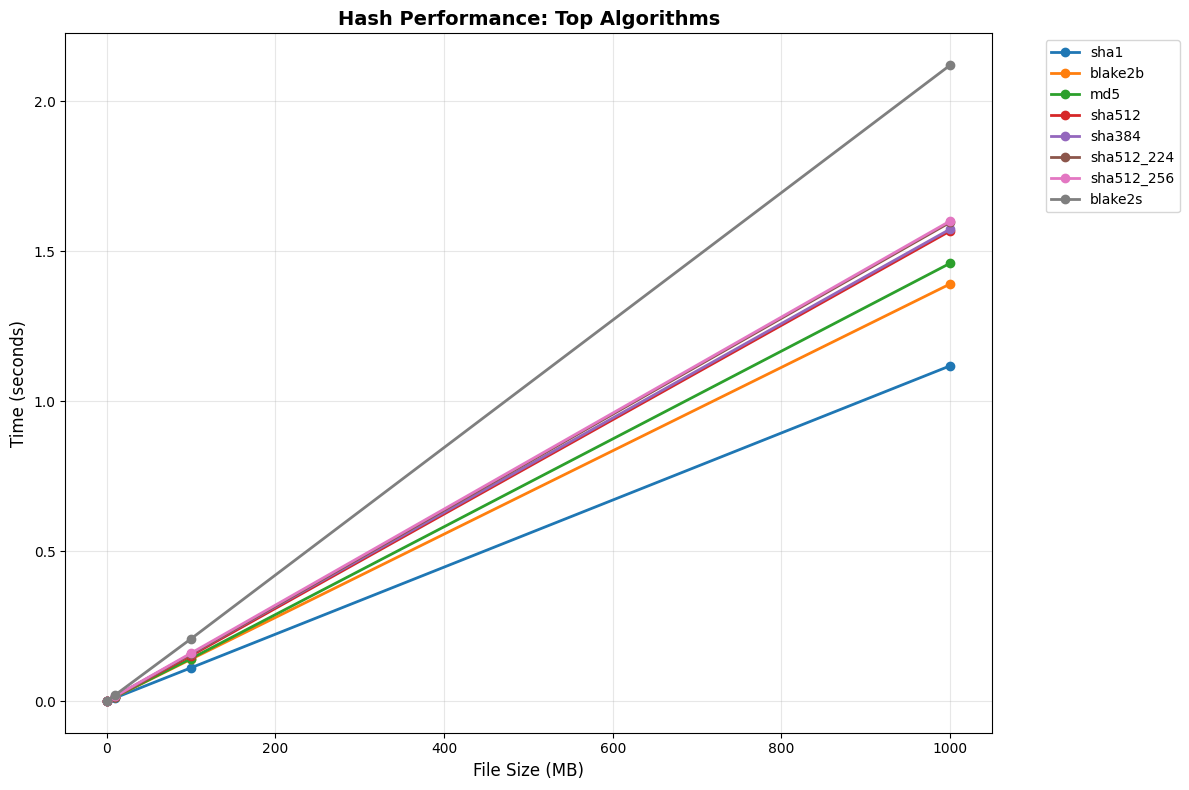

In [61]:
top_algorithms = avg_times.head(8).index

plt.figure(figsize=(12, 8))
for algo in top_algorithms:
    algo_data = df_results[df_results['algorithm'] == algo]
    plt.plot(algo_data['file_size_mb'], algo_data['time_seconds'], 
             marker='o', linewidth=2, label=algo)

plt.xlabel('File Size (MB)', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.title('Hash Performance: Top Algorithms', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

For file deduplication, the key requirement is speed rather than cryptographic strength. The goal is to quickly detect identical files, not to protect against deliberate hash collisions. SHA1 emerges as the fastest algorithm in our performance tests, making it an excellent choice for this purpose because it is extremely fast, widely supported, and its collision risk is negligible in non-adversarial contexts.
   
Modern alternatives like BLAKE2b offer competitive performance with stronger hash properties, making them excellent choices for large-scale or performance-critical deduplication systems where both speed and security are important considerations.   

Key findings from our benchmarks:
- SHA1 consistently outperformed other algorithms across all file sizes tested
- MD5 remains a solid second choice for maximum compatibility
- BLAKE2 algorithms provide the best balance of speed and cryptographic strength
- Traditional algorithms like SHA256, while secure, are significantly slower for large-scale deduplication tasks